In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from matplotlib import pyplot
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree
import graphviz

In [2]:
import shap
from lime import lime_tabular

In [3]:
from sklearn.model_selection import cross_val_score

In [4]:
input_file='D:/学习资料/DataScience/TB2/Mini-project/model/AQI_X_data.csv'

data=pd.read_csv(input_file)
data = data[data['Year'] > 2019]
data = data.drop(['geo_point_2d','ZipCode','Type of tree','Longitude','Latitude'],axis=1)
data = data.rename({'left_ZipCode':'Outcode'})
#delete Tree air clean
#data = data.drop(data.columns[-3:], axis=1)

Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.


Add the EV data

In [58]:
input_file='D:/学习资料/DataScience/TB2/Mini-project/model/AQI_X_data.csv'

data=pd.read_csv(input_file)

data = data[data['Year'] > 2019]
data = data.drop(['geo_point_2d','ZipCode','Type of tree'],axis=1)
#delete Tree air clean
#data = data.drop(data.columns[-3:], axis=1)

Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.


In [6]:
EV_quater_df = pd.read_csv('D:/学习资料/DataScience/TB2/Mini-project/data_cleaning/EV_Quater.csv')   
EV_quater_df['Heavy goods vehicles'] = 5


EV_quater_df['Cars'] = EV_quater_df['Cars'].astype(int)
EV_quater_df['Heavy goods vehicles'] = EV_quater_df['Heavy goods vehicles'].astype(int)
EV_quater_df['Light goods vehicles'] = EV_quater_df['Light goods vehicles'].astype(int)
EV_quater_df['Motorcycles'] = EV_quater_df['Motorcycles'].astype(int)
EV_quater_df['Total'] = EV_quater_df['Total'].astype(int)
#EV_quater_df.iloc[:, 1:] = EV_quater_df.iloc[:, 1:].astype(int)

EV_quater_df['Other vehicles'] =EV_quater_df['Total']-EV_quater_df['Heavy goods vehicles']-EV_quater_df['Cars']-EV_quater_df['Light goods vehicles']-EV_quater_df['Motorcycles']


merge the EV data

In [7]:
data['Quater'] = data['Month'].apply(lambda x: 'Q1' if x <= 3 else ('Q2' if x <= 6 else ('Q3' if x <= 9 else 'Q4')))
data = data.merge(EV_quater_df,left_on=['Quater'],right_on=['Time'],how='left')
data = data.drop(['Time'],axis=1)
data['Quater'] = data['Month'].apply(lambda x: '1' if x == 'Q1' else ('2' if x == 'Q2' else ('3' if x == 'Q3' else '4'))).astype(int)
#data = data.drop(['Longitude','Latitude'],axis=1)

show data

In [8]:
#data=data.groupby(['Year','Month','Day','Hour']).mean().reset_index(drop=False)


#data=data.dropna()
print(data.shape,data.isna().sum())
#data.to_csv('D:/学习资料/DataScience/TB2/Mini-project/model/'+'test_data.csv', index=False)
data

(190957, 29) Year                                        0
Month                                       0
Day                                         0
Hour                                        0
max_AQI                                     0
Longitude                                   0
Latitude                                    0
left_ZipCode                                0
Hourly Flow                             72503
Hourly Profile                          72503
Temperature                             62968
Dewpoint Temperature                    62968
Wind Speed                              62968
Visibility                              62968
Wind Chill Temperature                  62968
Relative Humidity                      106272
Daily lab-confirmed cases               61931
Cumulative lab-confirmed cases          61931
Cumulative lab-confirmed cases rate     66111
tree_airclean_0                        190917
tree_airclean_1                        190917
tree_airclean_2      

,Year,Month,Day,Hour,max_AQI,Longitude,Latitude,left_ZipCode,Hourly Flow,Hourly Profile,...,tree_airclean_0,tree_airclean_1,tree_airclean_2,Quater,Cars,Heavy goods vehicles,Light goods vehicles,Motorcycles,Other vehicles,Total
0,2020,1,1,0,2,51.427864,-2.563742,BS14,76.0,72.0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,1,1,0,2,51.455269,-2.596649,BS1,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,1,1,0,3,51.457950,-2.583989,BS2,371.2,209.6,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,1,1,0,2,51.462829,-2.584541,BS2,371.2,209.6,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,1,1,1,7,51.427864,-2.563742,BS14,136.0,32.0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190952,2022,12,31,15,2,51.455269,-2.596649,BS1,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
190953,2022,12,31,15,1,51.457950,-2.583989,BS2,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
190954,2022,12,31,15,1,51.459142,-2.595433,BS1,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
190955,2022,12,31,15,2,51.462829,-2.584541,BS2,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Encode the ZipCode
le = LabelEncoder()

cols_to_transform = ['left_ZipCode']

data[cols_to_transform] = data[cols_to_transform].astype(str)

data[cols_to_transform] = data[cols_to_transform].apply(lambda x: le.fit_transform(x.astype(str)))
data=data.fillna(0)

In [10]:
X = data.drop(['max_AQI'], axis=1)
y = data['max_AQI'].apply(lambda x: x - 1)

In [11]:
X

,Year,Month,Day,Hour,Longitude,Latitude,left_ZipCode,Hourly Flow,Hourly Profile,Temperature,...,tree_airclean_0,tree_airclean_1,tree_airclean_2,Quater,Cars,Heavy goods vehicles,Light goods vehicles,Motorcycles,Other vehicles,Total
0,2020,1,1,0,51.427864,-2.563742,1,76.0,72.0,5.5,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
1,2020,1,1,0,51.455269,-2.596649,0,0.0,0.0,5.5,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
2,2020,1,1,0,51.457950,-2.583989,3,371.2,209.6,5.5,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
3,2020,1,1,0,51.462829,-2.584541,3,371.2,209.6,5.5,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
4,2020,1,1,1,51.427864,-2.563742,1,136.0,32.0,5.0,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190952,2022,12,31,15,51.455269,-2.596649,0,0.0,0.0,11.0,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
190953,2022,12,31,15,51.457950,-2.583989,3,0.0,0.0,11.0,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
190954,2022,12,31,15,51.459142,-2.595433,0,0.0,0.0,11.0,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
190955,2022,12,31,15,51.462829,-2.584541,3,0.0,0.0,11.0,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# use LinearRegression to fill na values 
'''
X.replace('', np.nan, inplace=True)

for column in X.columns:
    if X[column].isnull().sum() > 0:
        lm = LinearRegression()
        X_train = X[X[column].notnull()]
        y_train = X_train.pop(column)
        X_test = X[X[column].isnull()]
        X_train = X_train.select_dtypes(include=np.number)
        X_test = X_test.select_dtypes(include=np.number)
        lm.fit(X_train, y_train)
        X.loc[X[column].isnull(), column] = lm.predict(X_test.select_dtypes(include=np.number))
'''

"\nX.replace('', np.nan, inplace=True)\n\nfor column in X.columns:\n    if X[column].isnull().sum() > 0:\n        lm = LinearRegression()\n        X_train = X[X[column].notnull()]\n        y_train = X_train.pop(column)\n        X_test = X[X[column].isnull()]\n        X_train = X_train.select_dtypes(include=np.number)\n        X_test = X_test.select_dtypes(include=np.number)\n        lm.fit(X_train, y_train)\n        X.loc[X[column].isnull(), column] = lm.predict(X_test.select_dtypes(include=np.number))\n"

In [13]:
'''
# split the train and test set
train = data.loc[(data.Year <= 2022) & (data.Month < 10)]
test = data.loc[(data.Year == 2022) & (data.Month >= 10)]

X_train = train.drop('max_AQI', axis=1)
y_train = train['max_AQI'].apply(lambda x: x - 1)

X_test = test.drop('max_AQI', axis=1)
y_test = test['max_AQI'].apply(lambda x: x - 1)
'''
# delete max_AQI  from datasets


"\n# split the train and test set\ntrain = data.loc[(data.Year <= 2022) & (data.Month < 10)]\ntest = data.loc[(data.Year == 2022) & (data.Month >= 10)]\n\nX_train = train.drop('max_AQI', axis=1)\ny_train = train['max_AQI'].apply(lambda x: x - 1)\n\nX_test = test.drop('max_AQI', axis=1)\ny_test = test['max_AQI'].apply(lambda x: x - 1)\n"

In [14]:
# 假设你有一个名为 X 的特征矩阵和一个名为 y 的目标变量数组
# 将数据拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用 XGBClassifier 初始化一个分类器
clf = xgb.XGBClassifier(objective='binary:softprob', random_state=42)
#clf = xgb.XGBClassifier(objective='binary:logistic',learning_rate=0.02, n_estimators=600,silent=True, nthread=1)

In [15]:
'''
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

        
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
'''


"\ndef timer(start_time=None):\n    if not start_time:\n        start_time = datetime.now()\n        return start_time\n    elif start_time:\n        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)\n        tmin, tsec = divmod(temp_sec, 60)\n        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))\n\n        \n# A parameter grid for XGBoost\nparams = {\n        'min_child_weight': [1, 5, 10],\n        'gamma': [0.5, 1, 1.5, 2, 5],\n        'subsample': [0.6, 0.8, 1.0],\n        'colsample_bytree': [0.6, 0.8, 1.0],\n        'max_depth': [3, 4, 5]\n        }\n"

# RandomizedSearchCV: finding the best hyper parameters

In [16]:
'''
# 进行网格搜索
folds = 3
param_comb = 5

#skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
#random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs= -1, cv=skf, verbose=3, random_state=1001 )

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs= -1, cv=5, verbose=3, random_state=1001 )

#cv_score = cross_val_score(clf, X_train, y_train, cv = 5, scoring = "accuracy")

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
#cv_score.fit(X_train, y_train)

timer(start_time) # timing ends here for "start_time" variable

'''


'\n# 进行网格搜索\nfolds = 3\nparam_comb = 5\n\n#skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)\n#random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, scoring=\'accuracy\', n_jobs= -1, cv=skf, verbose=3, random_state=1001 )\n\nrandom_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, scoring=\'accuracy\', n_jobs= -1, cv=5, verbose=3, random_state=1001 )\n\n#cv_score = cross_val_score(clf, X_train, y_train, cv = 5, scoring = "accuracy")\n\n# Here we go\nstart_time = timer(None) # timing starts from this point for "start_time" variable\nrandom_search.fit(X_train, y_train)\n#cv_score.fit(X_train, y_train)\n\ntimer(start_time) # timing ends here for "start_time" variable\n\n'

In [17]:
#print(np.mean(cv_score))

In [18]:
'''
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)
'''


"\nprint('\n All results:')\nprint(random_search.cv_results_)\nprint('\n Best estimator:')\nprint(random_search.best_estimator_)\nprint('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))\nprint(random_search.best_score_ * 2 - 1)\nprint('\n Best hyperparameters:')\nprint(random_search.best_params_)\nresults = pd.DataFrame(random_search.cv_results_)\nresults\n#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)\n"

In [19]:
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

Essien's grid search (similar way for search)

In [20]:
# hyperparam_tuning = GridSearchCV(clf, param_grid = params, cv = 5, n_jobs = -1, scoring = "accuracy")
# hyperparam_tuning.fit(X_train, y_train)

# #Output the best hyperparameters for XGBoost
# Best_param = hyperparam_tuning.best_params_
# print("Best parameters: \n")
# print(Best_param)

Model output

In [21]:
# clf = xgb.XGBClassifier(objective='binary:logistic',learning_rate=0.02, n_estimators=600,silent=True, nthread=1,
#                         subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8)


# 训练分类器
clf.fit(X_train, y_train)

# 预测测试集
y_pred = clf.predict(X_test)

# 计算精度得分
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 计算混淆矩阵
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_mat)


Accuracy: 0.7268014243820695
Confusion Matrix:
 [[11500  2100    36    11     5     1     2     0     2]
 [ 2915 10440   381    12     5     3     0     3     0]
 [  692  2189  2345    21    10     8     0     2     8]
 [  119   338   158   623     5     7     2     1     1]
 [   90   279    87    28   638     3     6     3     3]
 [   68   181    54    11    18   568    13     2    15]
 [   36   100    31     9     8    15   570     5     9]
 [   34    76    13     0    11     7    15   472    23]
 [   30    60    26     5     5     0     2    16   602]]


In [22]:
#image = xgb.to_graphviz(clf,rankdir='LR')
image = xgb.to_graphviz(clf,rankdir='UD')
format = 'png' #You should try the 'svg'

#Set a different dpi (work only if format == 'png')
image.graph_attr = {'dpi':'400'}

image.render('xgbtree', format = format)

'xgbtree.png'

In [23]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)


F1 Score: 0.720780507223087


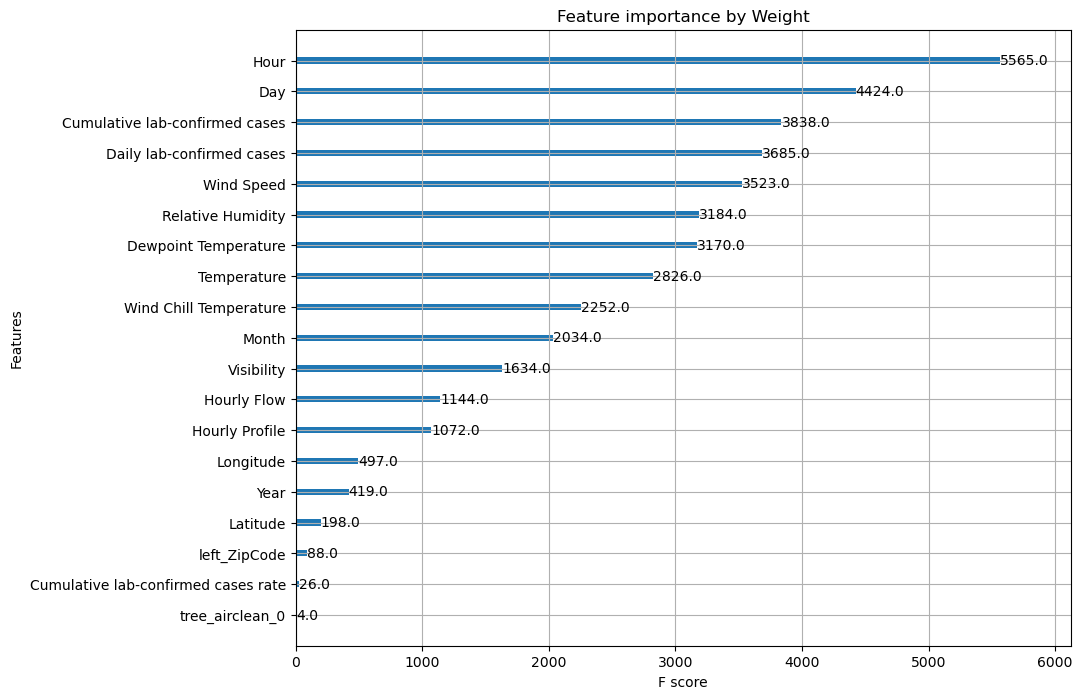

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
#xgb.plot_importance(clf, ax=ax)
xgb.plot_importance(clf, importance_type = 'weight',ax=ax,title='Feature importance by Weight ')
ax.set_title('Feature importance by Weight')
plt.show()
#the featureimportance is gain

In [25]:
fig.savefig('Feature importance by Weight.png', dpi=300, bbox_inches='tight')

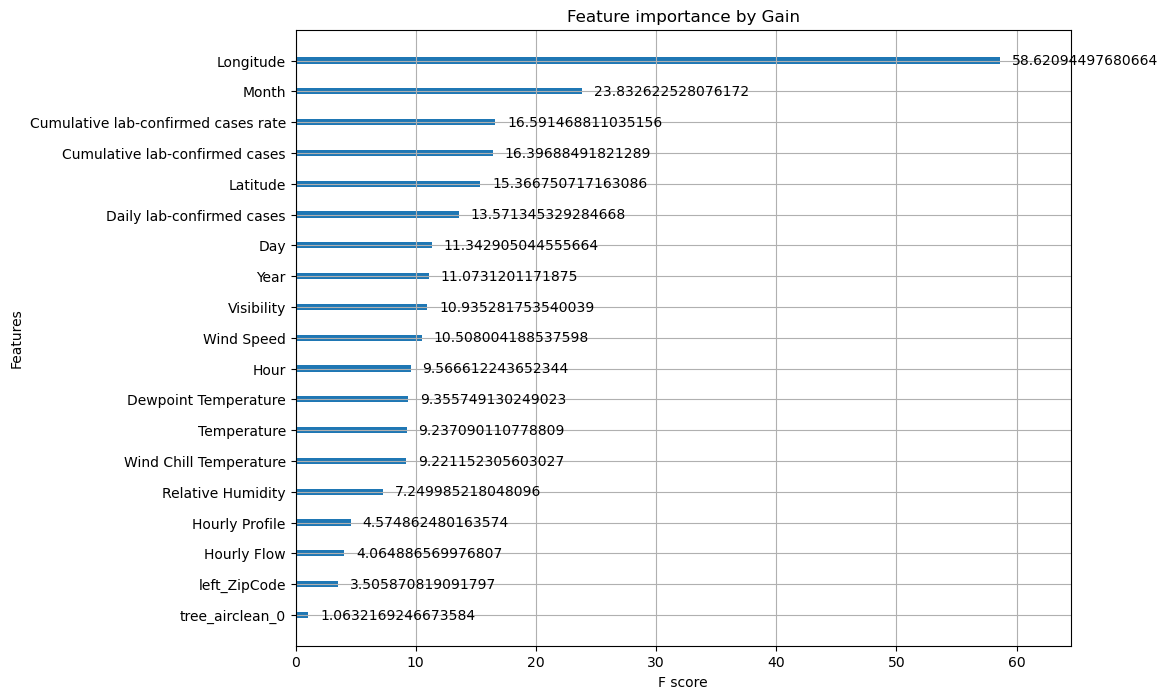

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
#xgb.plot_importance(clf, ax=ax)
xgb.plot_importance(clf, importance_type = 'gain',ax=ax,title='Feature importance by Gain ')
ax.set_title('Feature importance by Gain')
plt.show()
#the featureimportance is gain

In [27]:
fig.savefig('Feature importance by Gain.png', dpi=300, bbox_inches='tight')

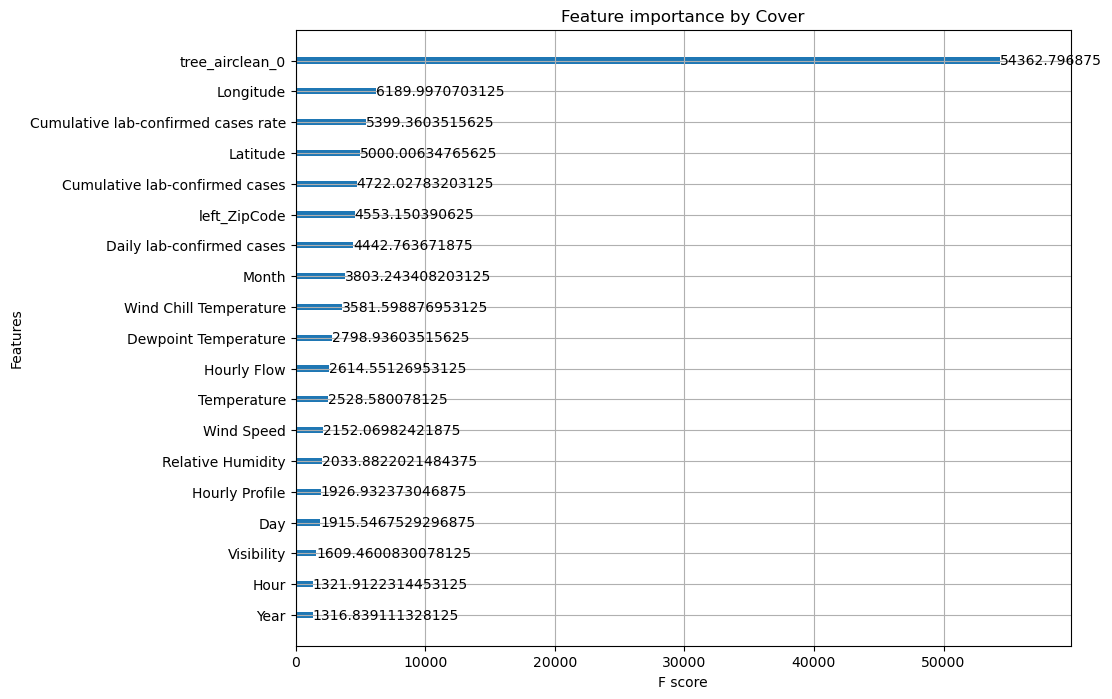

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
#xgb.plot_importance(clf, ax=ax)
xgb.plot_importance(clf, importance_type = 'cover',ax=ax,title='Feature importance by Cover ')
ax.set_title('Feature importance by Cover')
plt.show()
#the featureimportance is gain

In [29]:
fig.savefig('Feature importance by Cover.png', dpi=300, bbox_inches='tight')

In [30]:
ypred_df = pd.DataFrame({'Year': X_test['Year'],
                          'Month': X_test['Month'],
                          'Day': X_test['Day'],
                          'left_ZipCode': X_test['left_ZipCode'],
                          'AQI_true': y_test,
                          'AQI_pred': y_pred})
ypred_df = ypred_df.sort_values(['Year', 'Month', 'Day', 'left_ZipCode'])
ypred_df['left_ZipCode']= le.inverse_transform(ypred_df['left_ZipCode'])
ypred_df=ypred_df .reset_index(drop=True)
ypred_df
ypred_df.to_csv('D:/学习资料/DataScience/TB2/Mini-project/model/'+'classifier_output.csv', index=False)

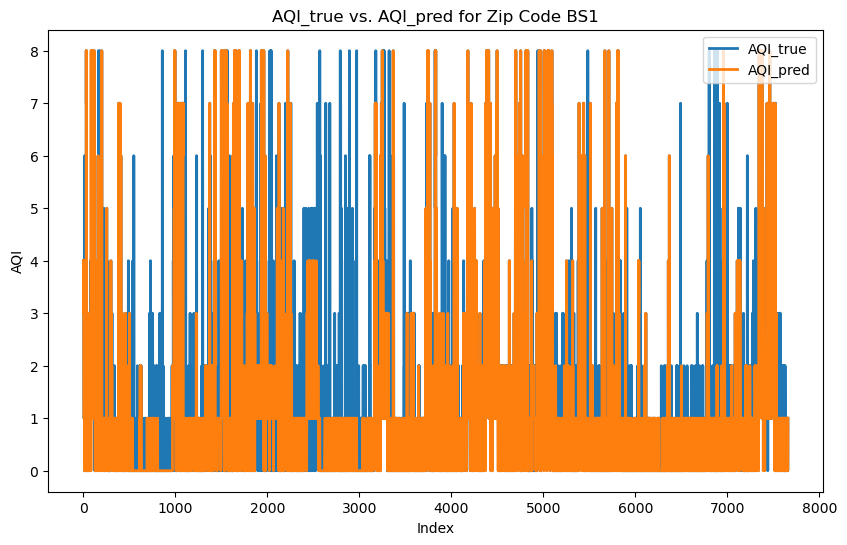

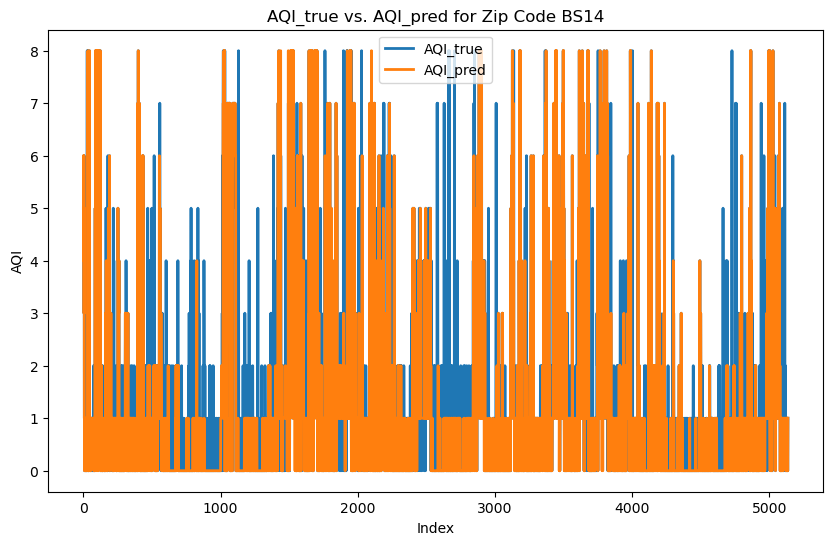

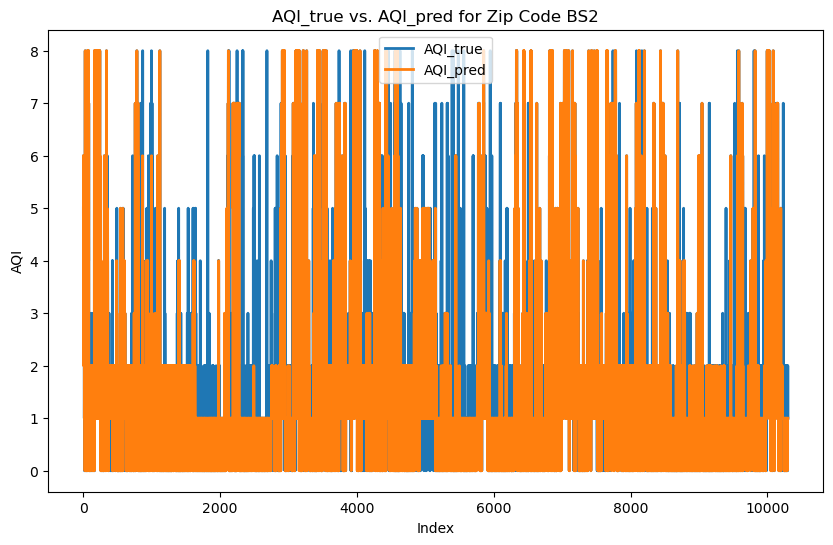

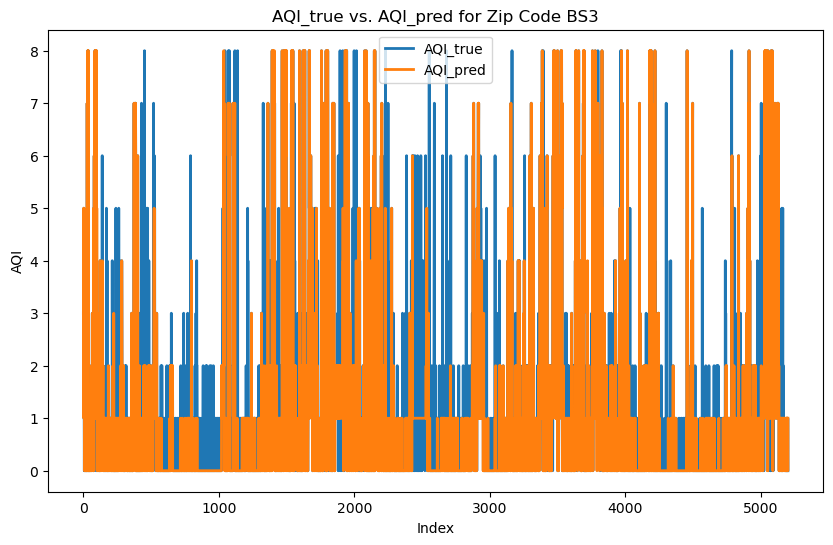

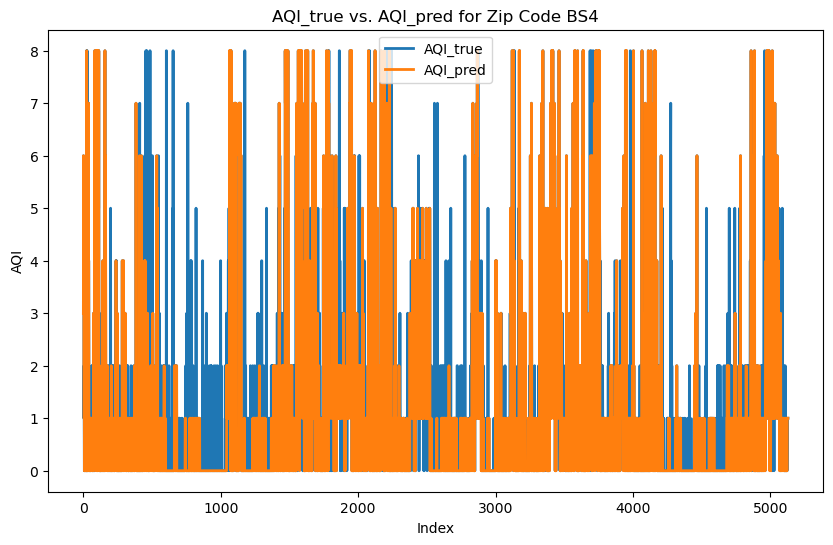

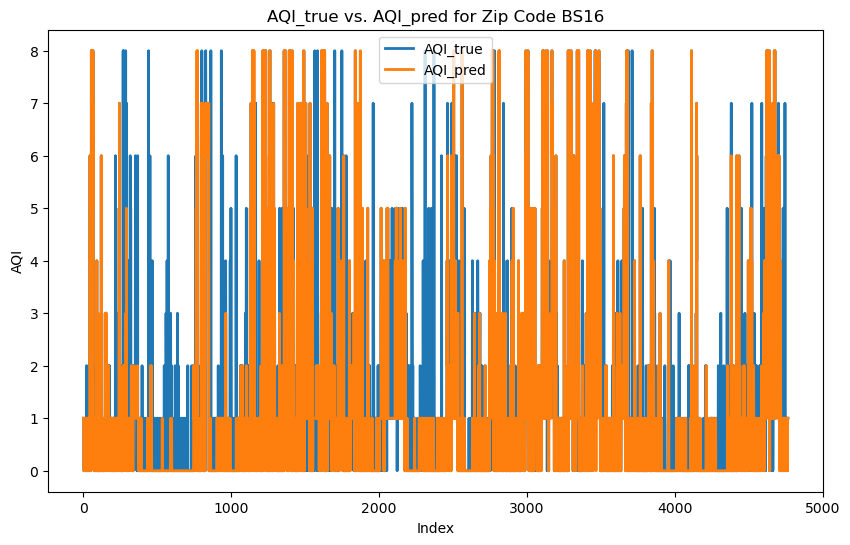

In [31]:
# 获取唯一的left_ZipCode值
zip_codes = ypred_df.left_ZipCode.unique()

# 遍历不同的left_ZipCode值，分别画出折线图
for zip_code in zip_codes:
    # 获取该left_ZipCode的数据
    df = ypred_df[ypred_df.left_ZipCode == zip_code]
    
    # 获取AQI_true和AQI_pred列的数据
    aqi_true = df.AQI_true.values
    aqi_pred = df.AQI_pred.values
    
    # 创建画布并画图
    plt.figure(figsize=(10, 6))
    plt.plot(aqi_true, label='AQI_true', linewidth=2)
    plt.plot(aqi_pred, label='AQI_pred', linewidth=2)
    plt.title('AQI_true vs. AQI_pred for Zip Code {}'.format(zip_code))
    plt.xlabel('Index')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()


In [32]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('MSE:', mse)
print('RMSE:', rmse)


MSE: 1.031655844155844
RMSE: 1.0157046047723934


In [33]:
#Save the image
#fig2.get_figure().savefig('feature_inportance.png',bbox_inches='tight',transparent=True)
#bbox_inches让图片显示完整，transparent=True让图片背景透明

# shap

In [34]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
#shap.plots.waterfall(shap_values[0])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X, show=False)
ax.set_xlim([-1, 1])  # 设置 x 轴的范围
ax.set_ylim([0, 20])  # 设置 y 轴的范围
plt.show()


In [ ]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X, show=False)
ax.set_xlim([-1, 1])
ax.set_ylim([0, 20])
ax.set_xlabel("SHAP value")
ax.set_ylabel("Feature")
fig.tight_layout() # 调整布局
plt.show()


In [ ]:
fig.savefig('shap_summary.png', dpi=300, bbox_inches='tight')

# Lime local explanation

In [ ]:
#!pip install lime

In [59]:
data_n = data.fillna(0)
X_n = X.fillna(0)

In [ ]:
'''
interpretor = lime_tabular.LimeTabularExplainer(training_data = np.array(X_n), 
                                                                feature_names = X_n.columns, 
                                                                class_names = y.unique(), 
                                                                mode = 'classification')
exp = interpretor.explain_instance(data_row = X_n.iloc[0], predict_fn = clf.predict_proba)
fig = exp.as_pyplot_figure()
plt.show()
'''

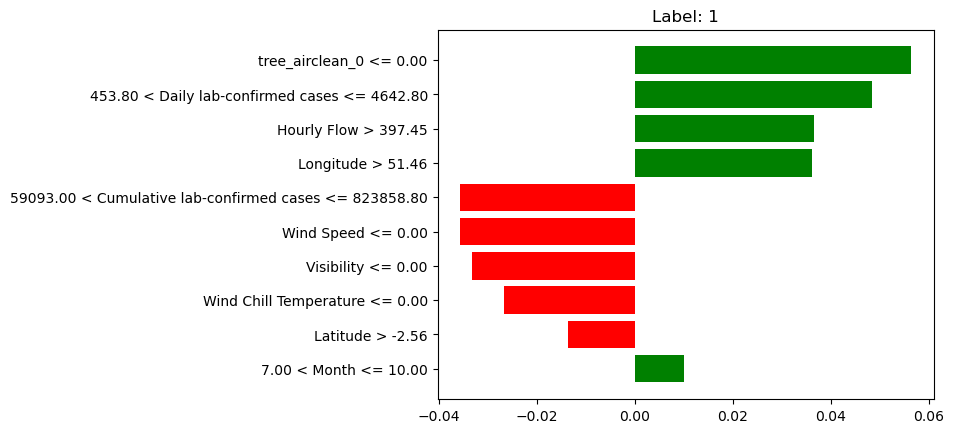

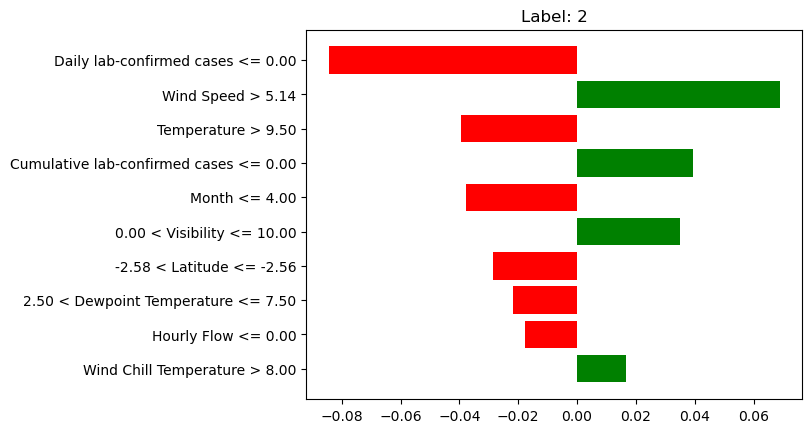

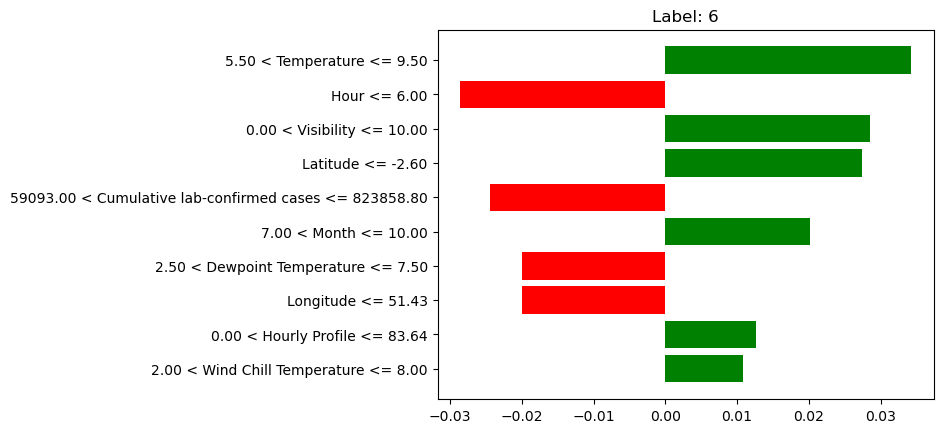

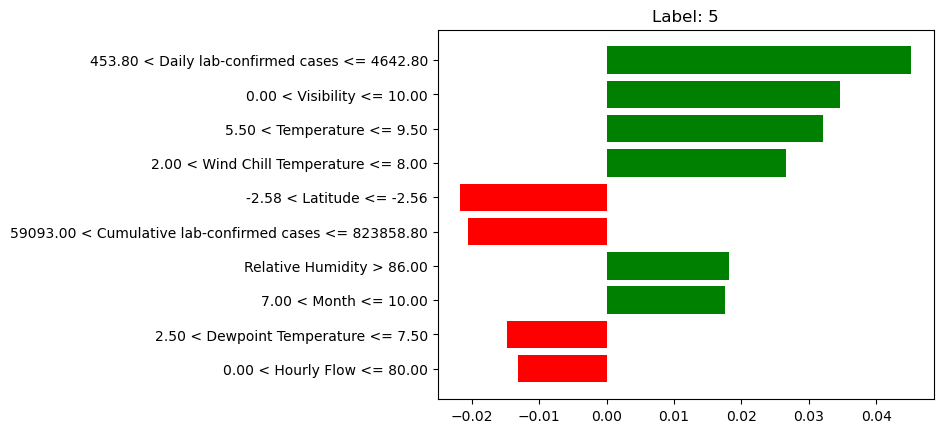

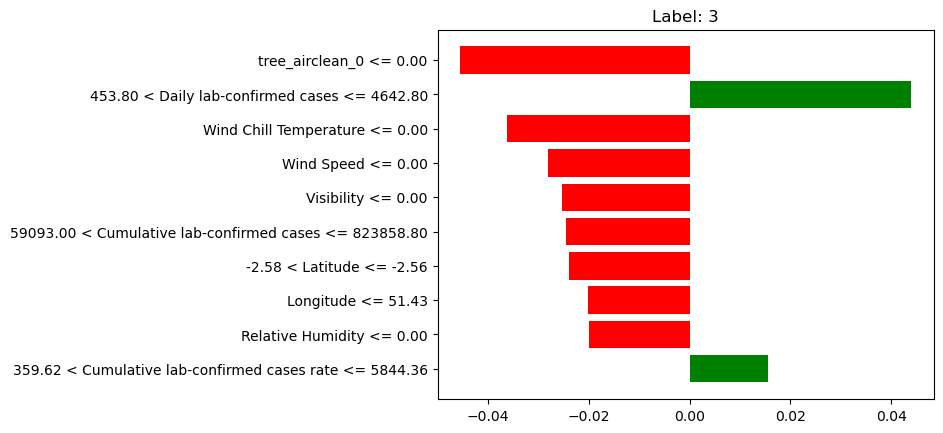

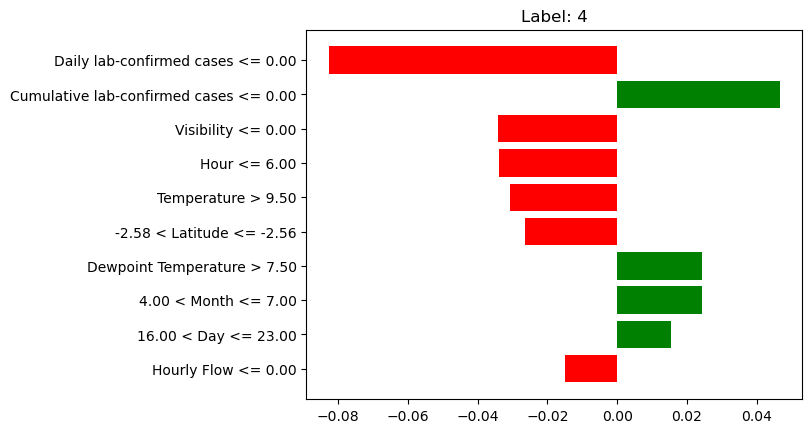

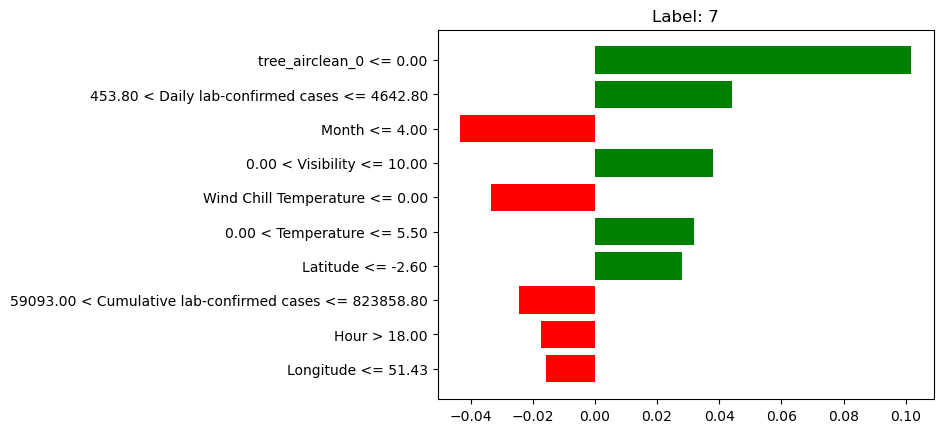

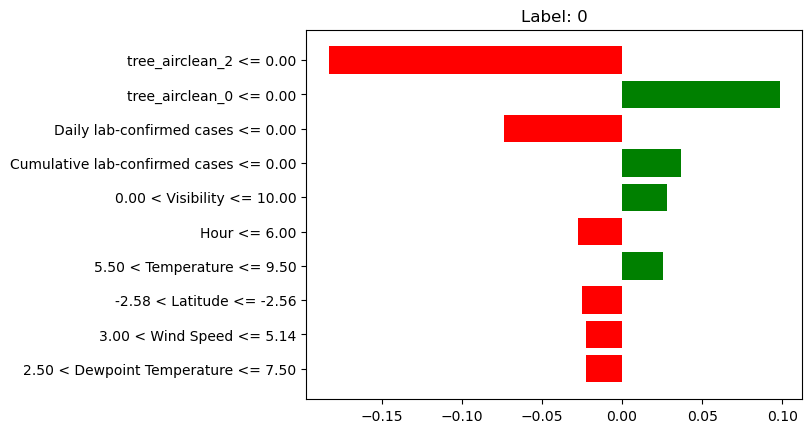

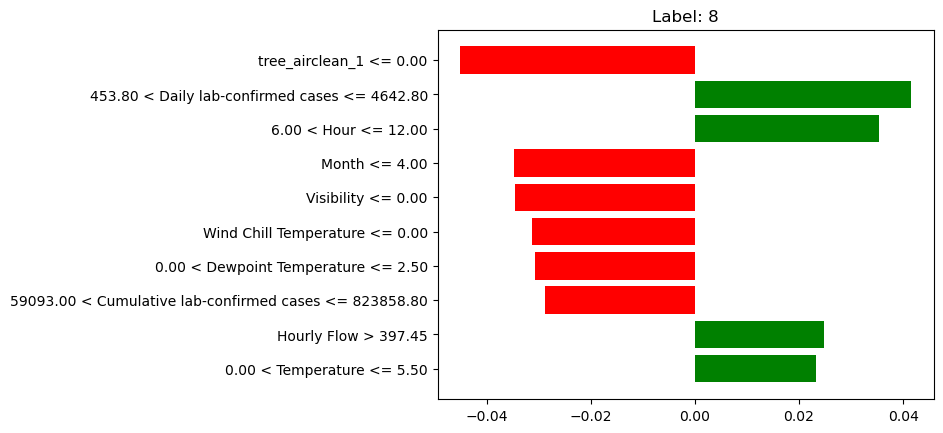

In [45]:
# 设置随机数种子
np.random.seed(123)

# 循环遍历y的每个唯一值
for label in y.unique():
    # 从X_n中随机抽出10行
    X_sample = X_n.loc[y == label].sample(n=1)
    
    # 遍历每一行，生成对应的LIME图
    for i in range(len(X_sample)):
        # 生成LIME图
        interpretor = lime_tabular.LimeTabularExplainer(training_data = np.array(X_n), 
                                                        feature_names = X_n.columns, 
                                                        class_names = y.unique(), 
                                                        mode = 'classification')
        exp = interpretor.explain_instance(data_row = X_sample.iloc[i], predict_fn = clf.predict_proba)
        fig = exp.as_pyplot_figure()
        
        # 显示LIME图
        plt.title('Label: {}'.format(label))
        plt.show()


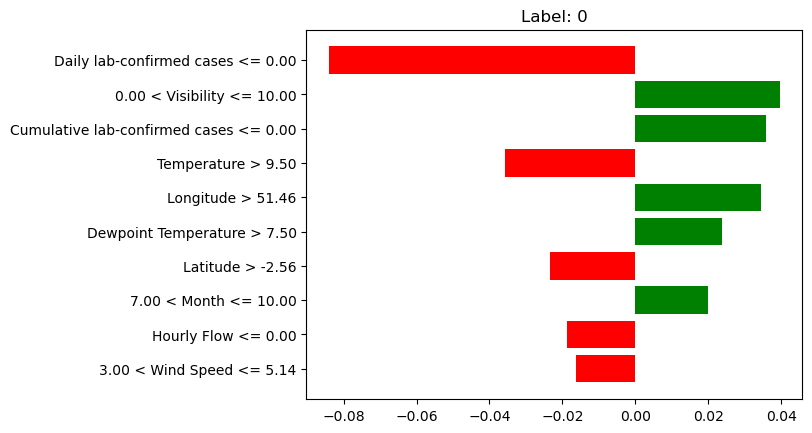

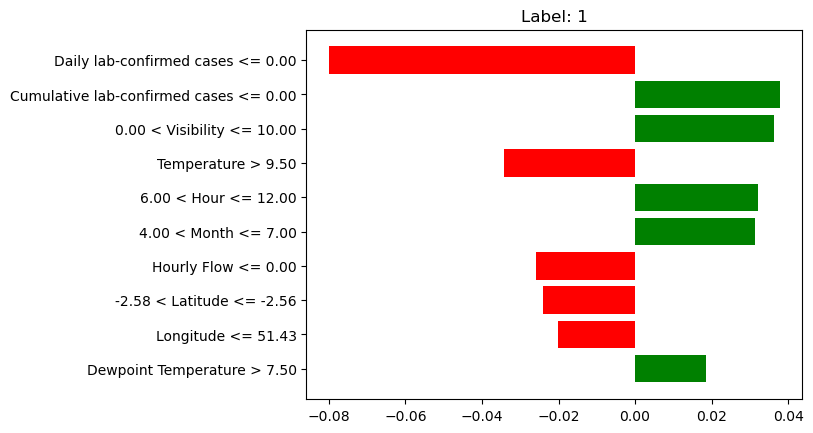

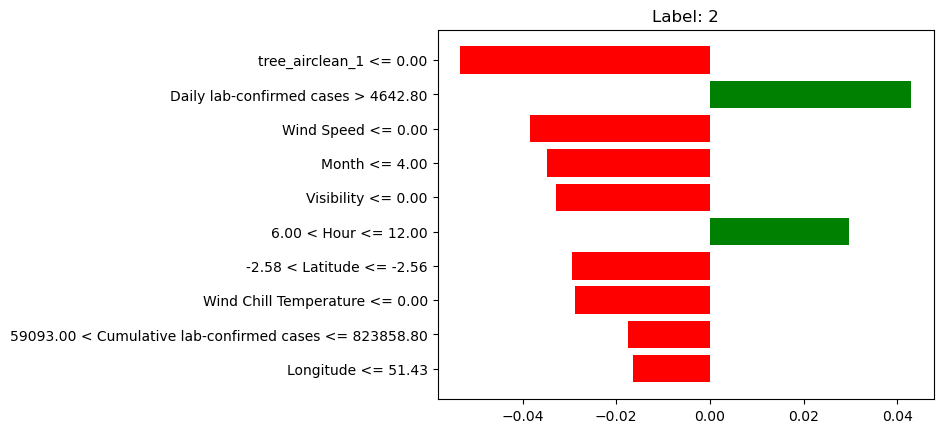

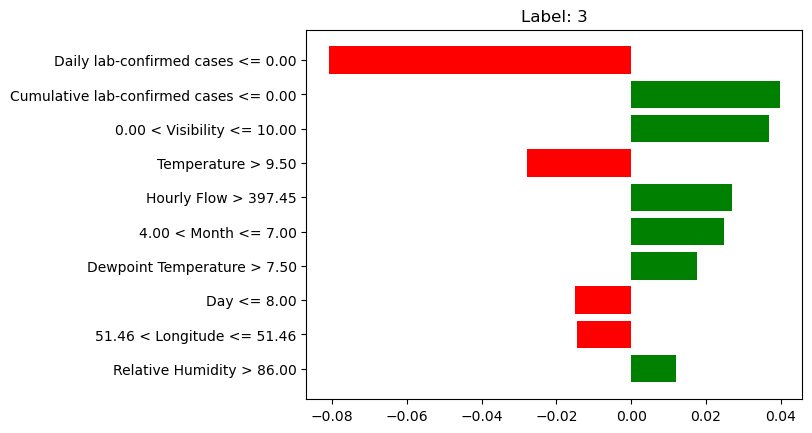

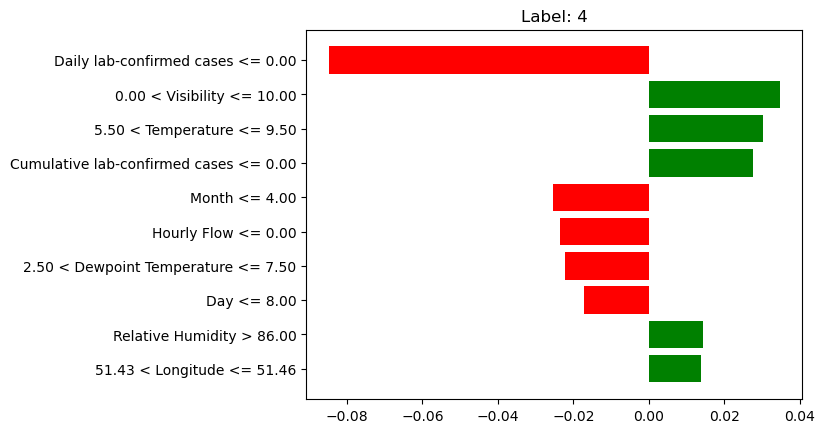

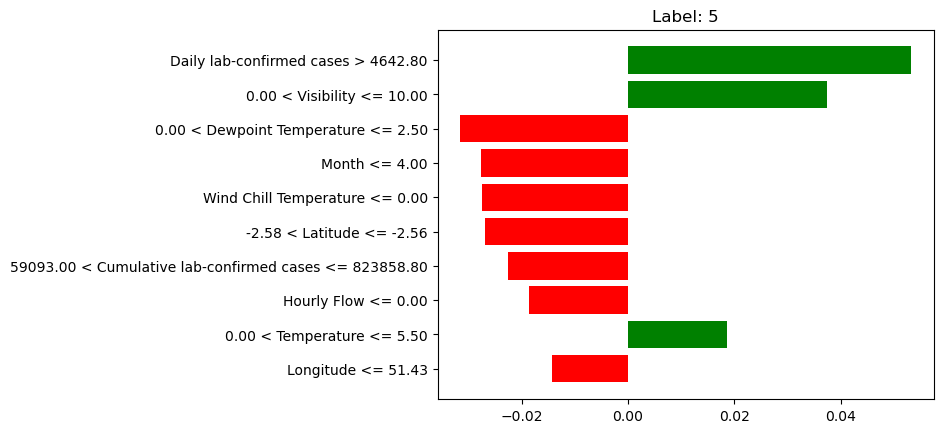

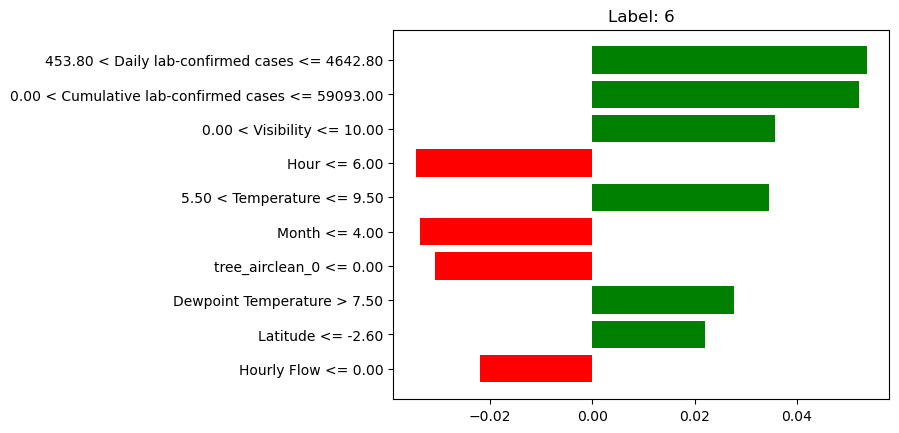

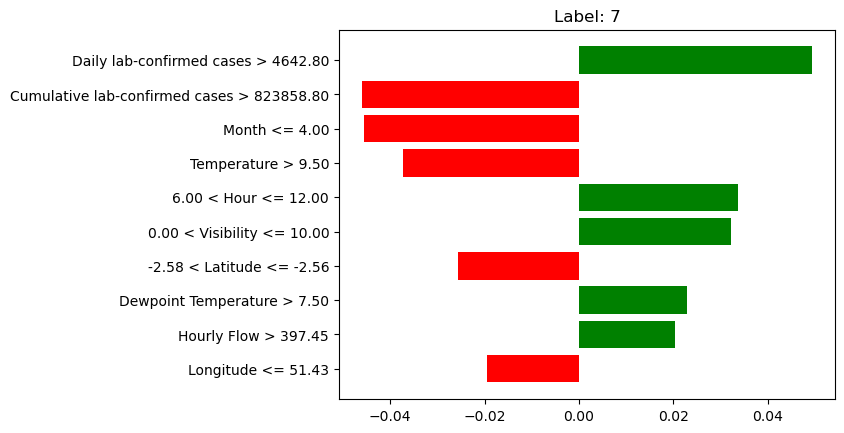

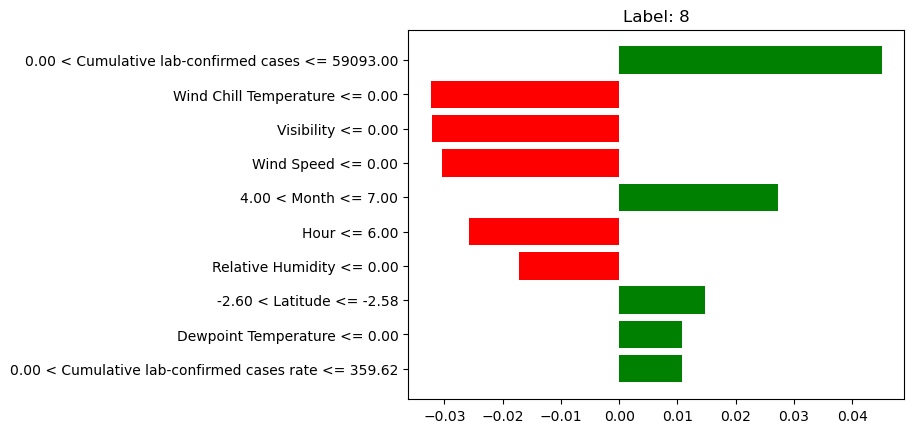

Label: 0
Exp: [('Daily lab-confirmed cases <= 0.00', -0.08402416711478158), ('0.00 < Visibility <= 10.00', 0.0395773417757269), ('Cumulative lab-confirmed cases <= 0.00', 0.03578397362359083), ('Temperature > 9.50', -0.0356789925867846), ('Longitude > 51.46', 0.03443727358418272), ('Dewpoint Temperature > 7.50', 0.02377927110937465), ('Latitude > -2.56', -0.023504559953393057), ('7.00 < Month <= 10.00', 0.019941188347904287), ('Hourly Flow <= 0.00', -0.018676710024585506), ('3.00 < Wind Speed <= 5.14', -0.016220512639070366)]
Label: 1
Exp: [('Daily lab-confirmed cases <= 0.00', -0.07995470589120472), ('Cumulative lab-confirmed cases <= 0.00', 0.03777994164399441), ('0.00 < Visibility <= 10.00', 0.03630832946138024), ('Temperature > 9.50', -0.034186579145542594), ('6.00 < Hour <= 12.00', 0.03217138720895598), ('4.00 < Month <= 7.00', 0.03132246976923951), ('Hourly Flow <= 0.00', -0.02575782757420397), ('-2.58 < Latitude <= -2.56', -0.024146908235780293), ('Longitude <= 51.43', -0.020178

In [176]:
# 设置随机数种子
np.random.seed(123)


# 将y.unique的顺序改为从数字0-8的升序
label_order = np.sort(y.unique())

# 储存每个label对应的exp的字典
exp_dict = {}

# 循环遍历y的每个唯一值
for label in label_order:
    # 从X_n中随机抽出10行
    X_sample = X_n.loc[y == label].sample(n=1)
    
    # 遍历每一行，生成对应的LIME图
    for i in range(len(X_sample)):
        # 生成LIME图
        interpretor = lime_tabular.LimeTabularExplainer(training_data = np.array(X_n), 
                                                        feature_names = X_n.columns, 
                                                        class_names = label_order, 
                                                        mode = 'classification')
        exp = interpretor.explain_instance(data_row = X_sample.iloc[i], predict_fn = clf.predict_proba)
        
        # 将label和对应的exp储存到字典中
        exp_dict[label] = exp
        
        # 显示LIME图
        fig = exp.as_pyplot_figure()
        plt.title('Label: {}'.format(label))
        plt.savefig('lime_{}.png'.format(label), dpi=300, bbox_inches='tight') # 保存LIME图
        plt.show()

# 打印每个label对应的exp
for label, exp in exp_dict.items():
    print('Label:', label)
    print('Exp:', exp.as_list())


In [179]:
# 将字典转换为列表
exp_list = []
for label, exp in exp_dict.items():
    exp_list.append({'Label': label, 'Exp': exp.as_list()})

# 将列表转换为 DataFrame
exp_df = pd.DataFrame(exp_list)
exp_df

,Label,Exp
0,0,"[(Daily lab-confirmed cases <= 0.00, -0.084024..."
1,1,"[(Daily lab-confirmed cases <= 0.00, -0.079954..."
2,2,"[(tree_airclean_1 <= 0.00, -0.0533405547604132..."
3,3,"[(Daily lab-confirmed cases <= 0.00, -0.080886..."
4,4,"[(Daily lab-confirmed cases <= 0.00, -0.084794..."
5,5,"[(Daily lab-confirmed cases > 4642.80, 0.05324..."
6,6,[(453.80 < Daily lab-confirmed cases <= 4642.8...
7,7,"[(Daily lab-confirmed cases > 4642.80, 0.04947..."
8,8,[(0.00 < Cumulative lab-confirmed cases <= 590...
